In [1]:
using LinearAlgebra

### Energy Function to Optimize
$$f(X) = \sum_{i \neq j} \frac{1}{||x_i - x_j||^2}$$
$$||x_i|| = ||x_j|| = 1$$

In [2]:
function potential_energy(X)
    # Compute the potential energy of the particle configuration
    n = size(X,2)
    energy = 0.0
    for i in 1:n-1
        for j in i+1:n
            r = norm(X[:,i] - X[:,j])
            energy += 1 / r^2
        end
    end
    return energy
end

potential_energy (generic function with 1 method)

### Gradient of Energy Function
$$g(X) = \nabla f(X)$$
$$\frac{\partial f}{\partial x_i} = \sum_{j \neq i} \frac{-2(x_i - x_j)}{||x_i - x_j||^4}$$
$$\frac{\partial f}{\partial x_j} = \sum_{i \neq j} \frac{2(x_i - x_j)}{||x_i - x_j||^4}$$
$$||x_i|| = ||x_j|| = 1$$

In [3]:
function gradient(X)
    # Compute the gradient of the potential energy
    k = size(X,1)
    n = size(X,2)
    G = zeros(k, n)
    for i in 1:n-1
        for j in i+1:n
            z = X[:,i] - X[:,j]
            r = norm(z)
            G[:,i] += -2*z / r^4
            G[:,j] += 2*z / r^4
        end
    end
    return G
end

gradient (generic function with 1 method)

### Gradient Check Code
Using the source code from Lecture 31

In [4]:
"""
    gradient_check(f, x, g)

Check that g seems to express the gradient of f by comparing
values computed with finite differences. This is based on the 
gradientcheck function in the Poblano Matlab toolbox.
"""
function gradient_check(f, x, g)
    fx = f(x) # computed function 
    gx = g(x) # putative gradient
    
    h = sqrt(eps(fx))
    xi = copy(x)
    gxd = copy(gx) 
    for i=1:length(x)
        xi[i] += h
        gxd[i] = (f(xi) - fx)/h
        xi[i] = x[i] # reset
    end
    absdiff = abs.(gxd .- gx)
    
    return (g=gx, gfd=gxd, maxdiff=maximum(absdiff), normdiff=norm(gxd - gx))
end

gradient_check

In [5]:
x = [0 1; 1 1; 1 0]
x = x ./ sqrt.(sum(x.^2, dims=1))
gradient_check(potential_energy, x, gradient).maxdiff

2.0500248831822887e-8

### Gradient Descent Algorithm
$$X_{k+1} = X_k - \alpha g(X_k)$$
$$||X_k|| = 1$$

In [6]:
function gradient_descent(X::Matrix, alpha::Float64, tol::Float64, max_iter::Int)
    # X = initial point
    # alpha = step size
    # tol = tolerance for convergence
    # max_iter = maximum number of iterations
    iter = 0
    prev_energy = potential_energy(X)
    while iter < max_iter
        G = gradient(X)
        X -= alpha .* G
        X = X ./ sqrt.(sum(X.^2, dims=1)) # re-normalize positions
        
        current_energy = potential_energy(X)
        if abs(current_energy - prev_energy) < tol
            print("Converged in ", iter, " iterations\n")
            break
        end
        prev_energy = current_energy
        iter += 1
    end
    
    return X
end

gradient_descent (generic function with 1 method)

### Thompson Problem
Implementation of the Thompson Problem using gradient descent, and a initial random point $X_0$

In [7]:
function random_thomson_problem(k::Int, n::Int, alpha::Float64, tol::Float64, max_iter::Int)
    # Initialize particle positions randomly on the unit sphere
    X = randn(k, n)
    X = X ./ sqrt.(sum(X.^2, dims=1))

    # Gradient Descent
    X = gradient_descent(X, alpha, tol, max_iter)
    
    return X
end

random_thomson_problem (generic function with 1 method)

Implementation of the Thompson Problem using GD and a given initial point $X_0$

In [8]:
function thomson_problem(X::Matrix, alpha::Float64, tol::Float64, max_iter::Int)
    X = X ./ sqrt.(sum(X.^2, dims=1))
    
    X = gradient_descent(X, alpha, tol, max_iter)
    
    return X
end

thomson_problem (generic function with 1 method)

### Plotting the Unit Sphere with 

In [9]:
using Plots

function plot_sphere(points::Matrix)
    # Define sphere meshgrid
    b = range(0, 2π, length=50)
    a = range(0, π, length=50)
    x = cos.(b) * sin.(a)'
    y = sin.(b) * sin.(a)'
    z = ones(length(b)) * cos.(a)'

    # Create plot with sphere and points
    p = plot(
        x, y, z, seriestype=:surface, color=:lightgrey, opacity=0.8,
        xlabel="x", ylabel="y", zlabel="z",
        title="Points on a sphere"
    )

    scatter!(
        points[1, :], points[2, :], points[3, :],
        markersize=5, color=:red, label="Points"
    )

    # Set camera and axis properties for interactivity
    plot!(p, camera=(30, 30), aspect_ratio=:equal)
    plot!(p, xlims=(-1, 1), ylims=(-1, 1), zlims=(-1, 1))
    plot!(p, legend=:bottomleft)

    return p
end

plot_sphere (generic function with 1 method)

### Some Results
$k=3, n=2$ to test the functions. That is, a 3D Sphere with just 2 particles.

In [17]:
X = random_thomson_problem(3,2, 0.01, 1e-10, 10000)
fx = potential_energy(X)
gx = gradient(X)
print("Energy: ", fx, "\nGrad: ", norm(gx), "\nX1 Norm: ", norm(X[1:3]), "\nX2 Norm: ", norm(X[4:6]))
X

Converged in 2226 iterations
Energy: 0.2500000198987676
Grad: 0.35355343280493495
X1 Norm: 0.9999999999999998
X2 Norm: 0.9999999999999998

3×2 Matrix{Float64}:
 -0.195243   0.195684
 -0.961936   0.961784
  0.191203  -0.191521

In [18]:
X0 = [0 0; 0.5 1; 0.3 -1]
X = thomson_problem(X0, 0.01,1e-10,6000)
fx = potential_energy(X)
gx = gradient(X)
print("Energy: ", fx, "\nGrad: ", norm(gx), "\nX1 Norm: ", norm(X[1:3]), "\nX2 Norm: ", norm(X[4:6]))
X

Converged in 3052 iterations
Energy: 0.25000001990329923
Grad: 0.35355343281454804
X1 Norm: 0.9999999999999998
X2 Norm: 0.9999999999999999

3×2 Matrix{Float64}:
 0.0        0.0
 0.122463  -0.121903
 0.992473  -0.992542

### Initial point is already a solution

In [19]:
X = [0.0 0.0; 1 -1; 0.0 0.0]
fx = potential_energy(X)
gx = gradient(X)
print("Energy: ", fx, "\nGrad: ", norm(gx), "\nX1 Norm: ", norm(X[1:3]), "\nX2 Norm: ", norm(X[4:6]))
X

Energy: 0.25
Grad: 0.3535533905932738
X1 Norm: 1.0
X2 Norm: 1.0

3×2 Matrix{Float64}:
 0.0   0.0
 1.0  -1.0
 0.0   0.0

### Problems with N > 2

Converged in 1227 iterations
Energy: 1.0000000074170166
Grad: 1.154700551230321

X1: [0.6110668536443618, -0.22837436630034905, -0.7579198171271777]
X2: [-0.03422559588462366, 0.9361058939951553, 0.3500490877203846]
X3: [-0.5770323083274942, -0.7076795862345169, 0.40770494033453475]

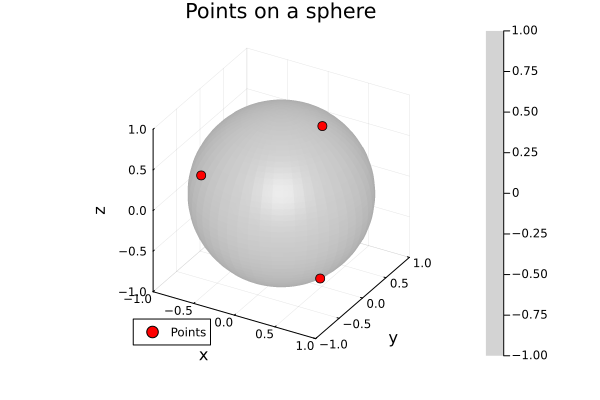

In [20]:
X = random_thomson_problem(3,3, 0.01, 1e-10, 10000)
fx = potential_energy(X)
gx = gradient(X)
print("Energy: ", fx, "\nGrad: ", norm(gx))
print("\n\nX1: ",X[:,1], "\nX2: ", X[:,2], "\nX3: ", X[:,3])
p = plot_sphere(X)
display(p)

Converged in 817 iterations
Energy: 2.2500000044034287
Grad: 2.2500000066073707

X1: [-0.6013364984519943, 0.78001004890544, -0.17314369534010704]
X2: [0.7712950132568656, 0.02617011168793704, -0.6359395629926893]
X3: [0.34072385632946434, 0.04368894522842683, 0.939147767815484]
X4: [-0.5106839870257885, -0.8498729167544212, -0.1300687924245366]

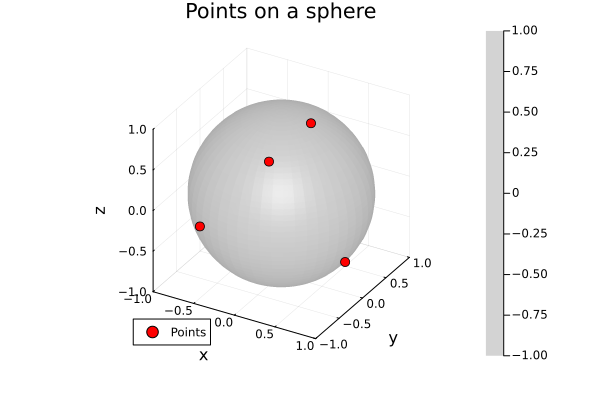

In [22]:
X = random_thomson_problem(3,4, 0.01, 1e-10, 10000)
fx = potential_energy(X)
gx = gradient(X)
print("Energy: ", fx, "\nGrad: ", norm(gx))
print("\n\nX1: ",X[:,1], "\nX2: ", X[:,2], "\nX3: ", X[:,3], "\nX4: ", X[:,4])
p = plot_sphere(X)
display(p)

Converged in 1776 iterations
Energy: 4.250000011674749
Grad: 3.802411527236387

X1: [-0.9402483099075852, -0.2398730208740341, -0.24164860763657353]
X2: [0.31449321494954185, -0.34003719516372466, -0.8862667339215029]
X3: [0.5829139470040455, -0.6676417544398869, 0.4631045433987824]
X4: [0.35743604461307876, 0.9073281827165547, -0.22134823888983546]
X5: [-0.314570347299781, 0.34017872126594373, 0.8861850451218202]

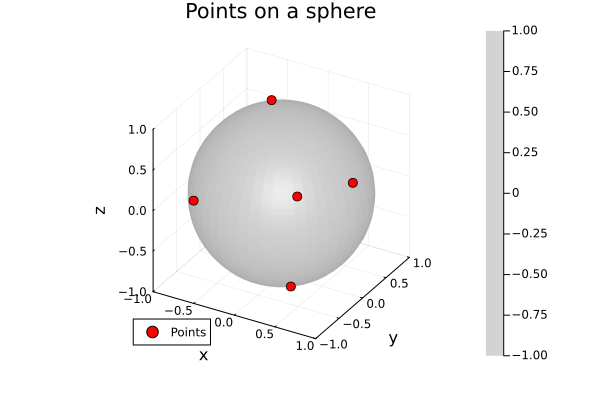

In [23]:
X = random_thomson_problem(3,5, 0.01, 1e-10, 10000)
fx = potential_energy(X)
gx = gradient(X)
print("Energy: ", fx, "\nGrad: ", norm(gx))
print("\n\nX1: ",X[:,1], "\nX2: ", X[:,2], "\nX3: ", X[:,3] ,"\nX4: ", X[:,4], "\nX5: ", X[:,5])
p = plot_sphere(X)
display(p)